# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
### No lateral constraints
### Fixed layers

In [1]:
#%matplotlib notebook

In [60]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [61]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers =[offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets+0.1, offsets*0, height]

# Frequency

freq = 9000

In [62]:
# parameters for the synthetic model

nlayer = 20 # number of layer
npos = 20 # number of sampling positions

resistivities = 10
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)
depth = np.linspace(0, 10, nlayer)

# Define a middle resistive layer:
depth1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
depth2 = depth1 + 2 + np.sin(x*np.pi*2) # wave


for i in range(npos):
    for j in range(nlayer):
        if (depth[j] >= depth1[i]) and (depth[j] <= depth2[i]):
            res[i, j] = 50
        

In [63]:

def PlotResistivities(res, npos, nlayer, Modelname):       
    
    fig, ax = plt.subplots()
    pos = ax.imshow(res.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Modelname)
        
    return 

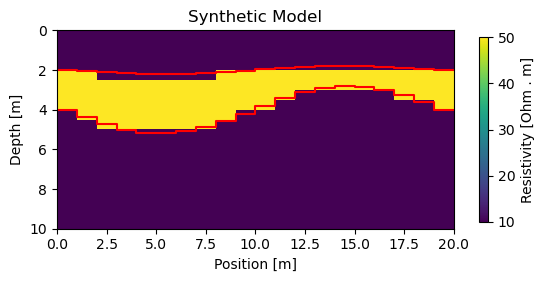

In [64]:
#Plot synthetic model

xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

PlotResistivities(res, npos, nlayer, 'Synthetic Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')


In [65]:
# Parameters for initial model

resistivities_ini = 10
res_ini = np.ones((npos, nlayer))*resistivities_ini


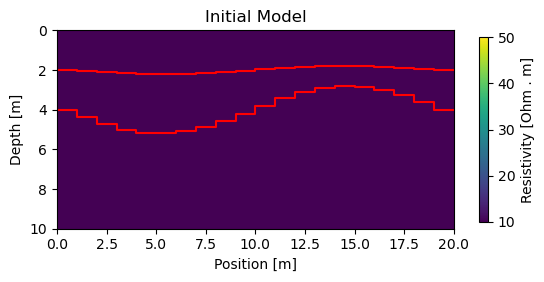

In [66]:
# Plot initial model

PlotResistivities(res_ini, npos, nlayer, 'Initial Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')

In [67]:
def EMforward_(res, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    res_air = 2e14
    resx = np.hstack((res_air, res))
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, resx, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
    
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)

    P_HCP = -np.real(HCP_Hs/HCP_Hp)
    P_VCP = np.real(VCP_Hs/VCP_Hp)
    P_PRP = np.real(PRP_Hs/PRP_Hp)
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [68]:
# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = res[i] # True model 
    data.append(EMforward_(model_i)) # creating data

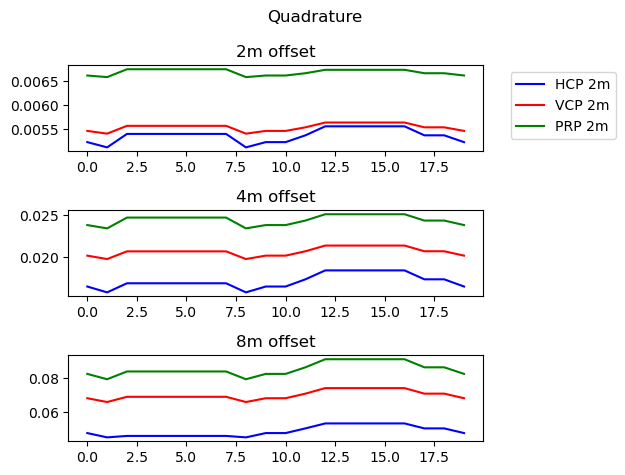

In [69]:
# Let's plot the data

data = np.array(data)
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data[:,0], 'b',label='HCP 2m')
ax1.plot(data[:,3], 'r',label='VCP 2m')
ax1.plot(data[:,6], 'g',label='PRP 2m')
ax1.set_title('2m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax2.plot(data[:,1], 'b',label='HCP 4m')
ax2.plot(data[:,4], 'r',label='VCP 4m')
ax2.plot(data[:,7], 'g',label='PRP 4m')
ax2.set_title('4m offset')

ax3.plot(data[:,2], 'b',label='HCP')
ax3.plot(data[:,5], 'r',label='VCP')
ax3.plot(data[:,8], 'g',label='PRP')
ax3.set_title('8m offset')

fig.suptitle('Quadrature')
plt.tight_layout()

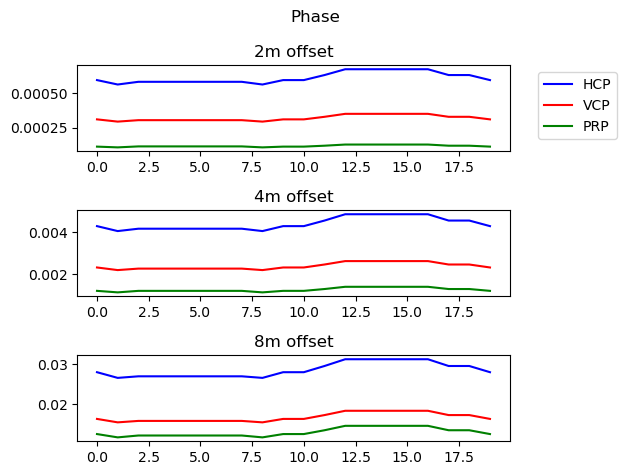

In [70]:
# Let's plot the data

data = np.array(data)
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data[:,9], 'b',label='HCP')
ax1.plot(data[:,12], 'r',label='VCP')
ax1.plot(data[:,15], 'g',label='PRP')
ax1.set_title('2m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax2.plot(data[:,10], 'b',label='HCP 4m')
ax2.plot(data[:,13], 'r',label='VCP 4m')
ax2.plot(data[:,16], 'g',label='PRP 4m')
ax2.set_title('4m offset')

ax3.plot(data[:,11], 'b',label='HCP')
ax3.plot(data[:,14], 'r',label='VCP')
ax3.plot(data[:,17], 'g',label='PRP')
ax3.set_title('8m offset')

fig.suptitle('Phase')

plt.tight_layout()

In [16]:
# Calculate normalization by coil and OP /IP

data = np.array(data)

# data shape is (npos, geometries * 2) 

Q_HCP_2 = data[:,0]
Q_HCP_4 = data[:,1]
Q_HCP_8 = data[:,2]
Q_VCP_2 = data[:,3]
Q_VCP_4 = data[:,4]
Q_VCP_8 = data[:,5]
Q_PRP_2 = data[:,6]
Q_PRP_4 = data[:,7]
Q_PRP_8 = data[:,8]

P_HCP_2 = data[:,9]
P_HCP_4 = data[:,10]
P_HCP_8 = data[:,11]
P_VCP_2 = data[:,12]
P_VCP_4 = data[:,13]
P_VCP_8 = data[:,14]
P_PRP_2 = data[:,15]
P_PRP_4 = data[:,16]
P_PRP_8 = data[:,17]

# Calculate L2 norm

L2_Q_HCP_2 = np.sqrt(np.sum(Q_HCP_2**2))
L2_Q_HCP_4 = np.sqrt(np.sum(Q_HCP_4**2))
L2_Q_HCP_8 = np.sqrt(np.sum(Q_HCP_8**2))

L2_Q_VCP_2 = np.sqrt(np.sum(Q_VCP_2**2))
L2_Q_VCP_4 = np.sqrt(np.sum(Q_VCP_4**2))
L2_Q_VCP_8 = np.sqrt(np.sum(Q_VCP_8**2))

L2_Q_PRP_2 = np.sqrt(np.sum(Q_PRP_2**2))
L2_Q_PRP_4 = np.sqrt(np.sum(Q_PRP_4**2))
L2_Q_PRP_8 = np.sqrt(np.sum(Q_PRP_8**2))

L2_P_HCP_2 = np.sqrt(np.sum(P_HCP_2**2))
L2_P_HCP_4 = np.sqrt(np.sum(P_HCP_4**2))
L2_P_HCP_8 = np.sqrt(np.sum(P_HCP_8**2))

L2_P_VCP_2 = np.sqrt(np.sum(P_VCP_2**2))
L2_P_VCP_4 = np.sqrt(np.sum(P_VCP_4**2))
L2_P_VCP_8 = np.sqrt(np.sum(P_VCP_8**2))

L2_P_PRP_2 = np.sqrt(np.sum(P_PRP_2**2))
L2_P_PRP_4 = np.sqrt(np.sum(P_PRP_4**2))
L2_P_PRP_8 = np.sqrt(np.sum(P_PRP_8**2))

L2_Q_HCP = np.hstack((L2_Q_HCP_2, L2_Q_HCP_4, L2_Q_HCP_8))
L2_Q_VCP = np.hstack((L2_Q_VCP_2, L2_Q_VCP_4, L2_Q_VCP_8))
L2_Q_PRP = np.hstack((L2_Q_PRP_2, L2_Q_PRP_4, L2_Q_PRP_8))

L2_P_HCP = np.hstack((L2_P_HCP_2, L2_P_HCP_4, L2_P_HCP_8))
L2_P_VCP = np.hstack((L2_P_VCP_2, L2_P_VCP_4, L2_P_VCP_8))
L2_P_PRP = np.hstack((L2_P_PRP_2, L2_P_PRP_4, L2_P_PRP_8))

L2 = np.stack((L2_Q_HCP, L2_Q_VCP, L2_Q_PRP, L2_P_HCP, L2_P_VCP, L2_P_PRP))

In [17]:
## Define Analytic normalized forwards

def EMforward_norm(res, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    res_air = 2e14
    resx = np.hstack((res_air, res))
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, resx, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
   
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)/L2[0]
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)/L2[1]
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)/L2[2]

    P_HCP = -np.real(HCP_Hs/HCP_Hp)/L2[3]
    P_VCP = np.real(VCP_Hs/VCP_Hp)/L2[4]
    P_PRP = np.real(PRP_Hs/PRP_Hp)/L2[5]
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [45]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, res):
        
        Z = EMforward_norm(res)
           
        return Z
        
    def createStartModel(self, dataVals):
        
        res_ini = np.ones(nlayer)*10
        return res_ini

Set-up Inversion

In [46]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [47]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data_norm = []

for i in range(npos):
    model_i = res[i] # True model 
    model.append(model_i)
    data_norm.append(EMforward_norm(model_i)) # creating data

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_norm[0]) * error

In [48]:
# Start inversion

model_est_list =[] # empty array to store the model estimated
chi2hist = [] # empty array to store the chi2 history
modelhist = [] # empty array to store the model history

for i in range(npos):
    
    dataE = np.array(data_norm[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=False, lam=1, maxIter=40)
    chi2hist.append(invEM.chi2History)
    modelhist.append(invEM.modelHistory)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

05/12/22 - 14:34:22 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:34:29 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:34:35 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:34:43 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:34:47 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:34:54 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:01 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:07 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:14 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:18 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:29 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:32 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:34 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:36 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:39 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:41 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
05/12/22 - 14:35:44 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:51 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


05/12/22 - 14:35:54 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]


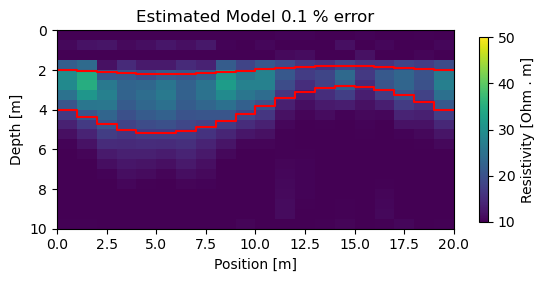

In [49]:
# Plot estimated model


PlotResistivities(model_est_arr, npos, nlayer, 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')

In [50]:
# Let's compare the two datasets

# Calculate data estimated model

data_est =[]

for i in range(npos):
    model_i = model_est_arr[i] # True model 
    data_est.append(EMforward_norm(model_i)) # creating data

data_true = np.array(data_norm)
data_est = np.array(data_est)

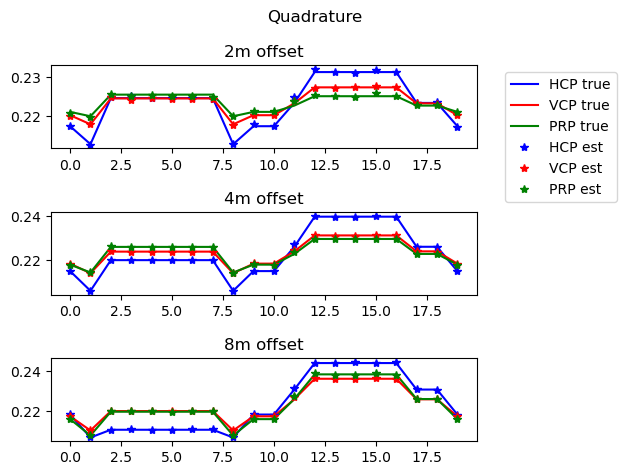

In [51]:
# Let's compare the data
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data_true[:,0], 'b',label='HCP true')
ax1.plot(data_true[:,3], 'r',label='VCP true')
ax1.plot(data_true[:,6], 'g',label='PRP true')
ax1.plot(data_est[:,0], '*b',label='HCP est')
ax1.plot(data_est[:,3], '*r',label='VCP est')
ax1.plot(data_est[:,6], '*g',label='PRP est')
ax1.set_title('2m offset')

ax2.plot(data_true[:,1], 'b',label='HCP 4m true')
ax2.plot(data_true[:,4], 'r',label='VCP 4m true')
ax2.plot(data_true[:,7], 'g',label='PRP 4m true')
ax2.plot(data_est[:,1], '*b',label='HCP 4m est')
ax2.plot(data_est[:,4], '*r',label='VCP 4m est')
ax2.plot(data_est[:,7], '*g',label='PRP 4m est')
ax2.set_title('4m offset')

ax3.plot(data_true[:,2], 'b',label='HCP true')
ax3.plot(data_true[:,5], 'r',label='VCP true')
ax3.plot(data_true[:,8], 'g',label='PRP true')
ax3.plot(data_est[:,2], '*b',label='HCP est')
ax3.plot(data_est[:,5], '*r',label='VCP est')
ax3.plot(data_est[:,8], '*g',label='PRP est')
ax3.set_title('8m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fig.suptitle('Quadrature')
plt.tight_layout()

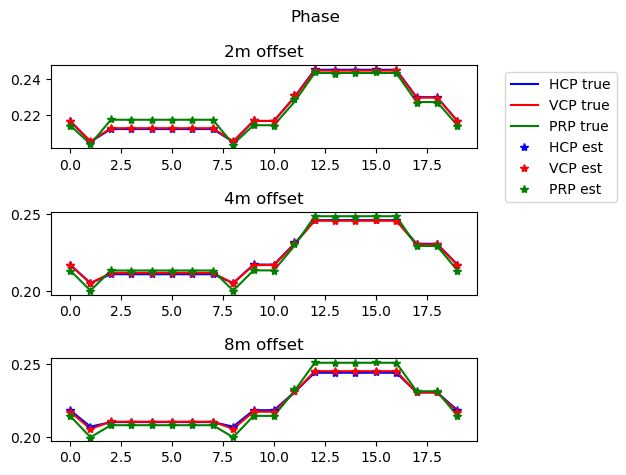

In [52]:
# Let's compare the data
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data_true[:,9], 'b',label='HCP true')
ax1.plot(data_true[:,12], 'r',label='VCP true')
ax1.plot(data_true[:,15], 'g',label='PRP true')
ax1.plot(data_est[:,9], '*b',label='HCP est')
ax1.plot(data_est[:,12], '*r',label='VCP est')
ax1.plot(data_est[:,15], '*g',label='PRP est')
ax1.set_title('2m offset')

ax2.plot(data_true[:,10], 'b',label='HCP 4m true')
ax2.plot(data_true[:,13], 'r',label='VCP 4m true')
ax2.plot(data_true[:,16], 'g',label='PRP 4m true')
ax2.plot(data_est[:,10], '*b',label='HCP 4m est')
ax2.plot(data_est[:,13], '*r',label='VCP 4m est')
ax2.plot(data_est[:,16], '*g',label='PRP 4m est')
ax2.set_title('4m offset')

ax3.plot(data_true[:,11], 'b',label='HCP 8m true')
ax3.plot(data_true[:,14], 'r',label='VCP 8m true')
ax3.plot(data_true[:,17], 'g',label='PRP 8m true')
ax3.plot(data_est[:,11], '*b',label='HCP 8m est')
ax3.plot(data_est[:,14], '*r',label='VCP 8m est')
ax3.plot(data_est[:,17], '*g',label='PRP 8m est')
ax3.set_title('8m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fig.suptitle('Phase')
plt.tight_layout()

Text(0, 0.5, 'chi2')

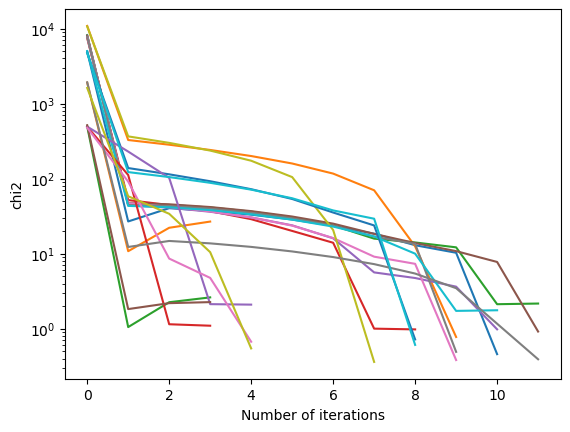

In [59]:
for i in range(len(chi2hist)):
    plt.semilogy(chi2hist[i])
plt.xlabel('Number of iterations')
plt.ylabel('chi2')